In [18]:
import numpy as np
import mxnet as mx
import random
random.seed(123)
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from skimage import transform as skimage_tf
from mxnet.contrib.ndarray import MultiBoxPrior, MultiBoxTarget, MultiBoxDetection, box_nms

from utils.iam_dataset import IAMDataset, resize_image, crop_image
from utils.expand_bounding_box import expand_bounding_box

from paragraph_segmentation_dcnn import make_cnn as ParagraphSegmentationNet
from line_segmentation import SSD as LineSegmentationNet
from word_segmentation import SSD as WordSegmentationNet
from handwriting_line_recognition import Network as HandwritingRecognitionNet
from handwriting_line_recognition import decode as decoder_handwriting

In [19]:
ctx = mx.gpu(0)

## Dataset creation

In [20]:
test_ds = IAMDataset("form_original", train=False)

In [21]:
figs_to_plot = 4
images = []

for i in range(0, figs_to_plot):
    n = int(random.random()*len(test_ds))
    image, _ = test_ds[n]
    images.append(image)

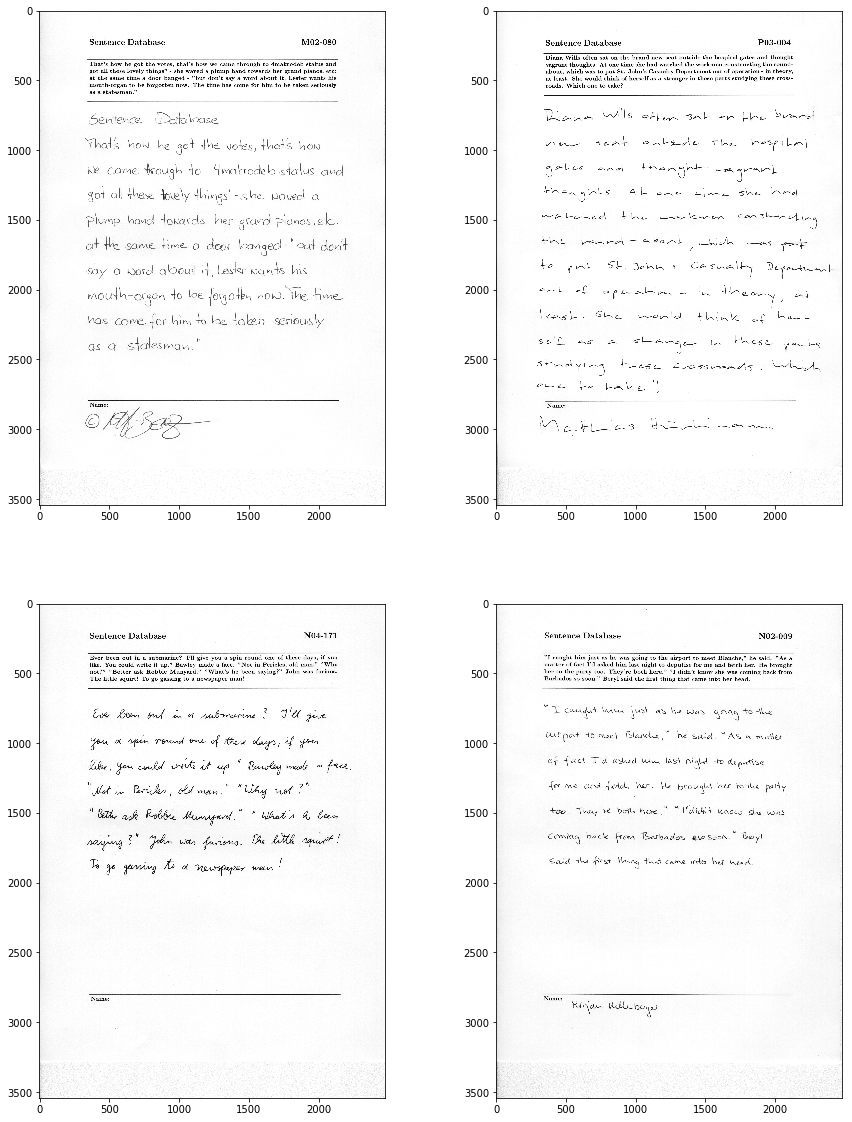

In [22]:
fig, axs = plt.subplots(int(len(images)/2), 2, figsize=(15, 10 * len(images)/2))
for i, image in enumerate(images):
    y, x = int(i/2), int(i%2)
    axs[y][x].imshow(image, cmap='Greys_r')

## Paragraph segmentation

In [23]:
paragraph_segmentation_net = ParagraphSegmentationNet()
paragraph_segmentation_net.load_parameters("models/paragraph_segmentation.params")

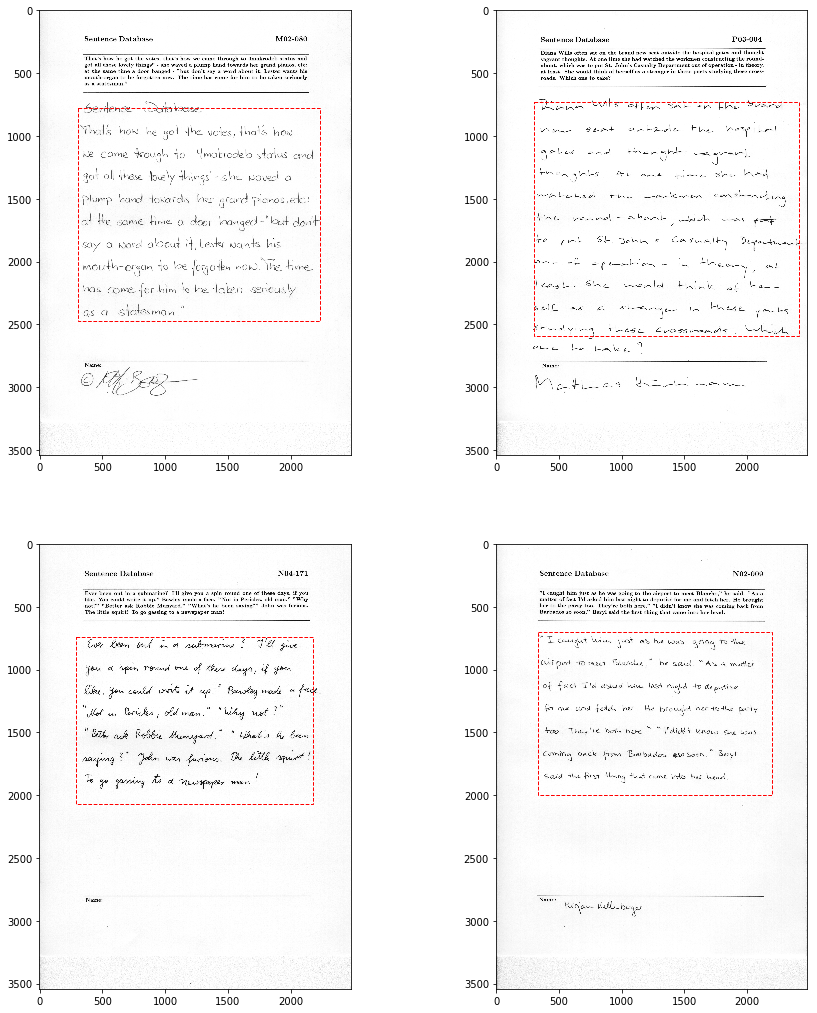

In [24]:
form_size = (1120, 800)
predicted_bbs = []

fig, axs = plt.subplots(int(len(images)/2), 2, figsize=(15, 9 * len(images)/2))
for i, image in enumerate(images):
    s_y, s_x = int(i/2), int(i%2)
    resized_image, _ = resize_image(image, form_size)
    
    resized_image = mx.nd.array(resized_image).expand_dims(axis=2)
    resized_image = mx.image.resize_short(resized_image, int(800/3))
    resized_image = resized_image.transpose([2, 0, 1])/255.

    resized_image = resized_image.as_in_context(ctx)
    resized_image = resized_image.expand_dims(axis=0)
    bb_predicted = paragraph_segmentation_net(resized_image)
    
    bb_predicted = bb_predicted[0].asnumpy()

    predicted_bbs.append(bb_predicted)
    
    axs[s_y, s_x].imshow(image, cmap='Greys_r')
    (x, y, w, h) = bb_predicted
    image_h, image_w = image.shape[-2:]
    (x, y, w, h) = (x * image_w, y * image_h, w * image_w, h * image_h)
    rect = patches.Rectangle((x, y), w, h, fill=False, color="r", ls="--")
    axs[s_y, s_x].add_patch(rect)

#### Image processing

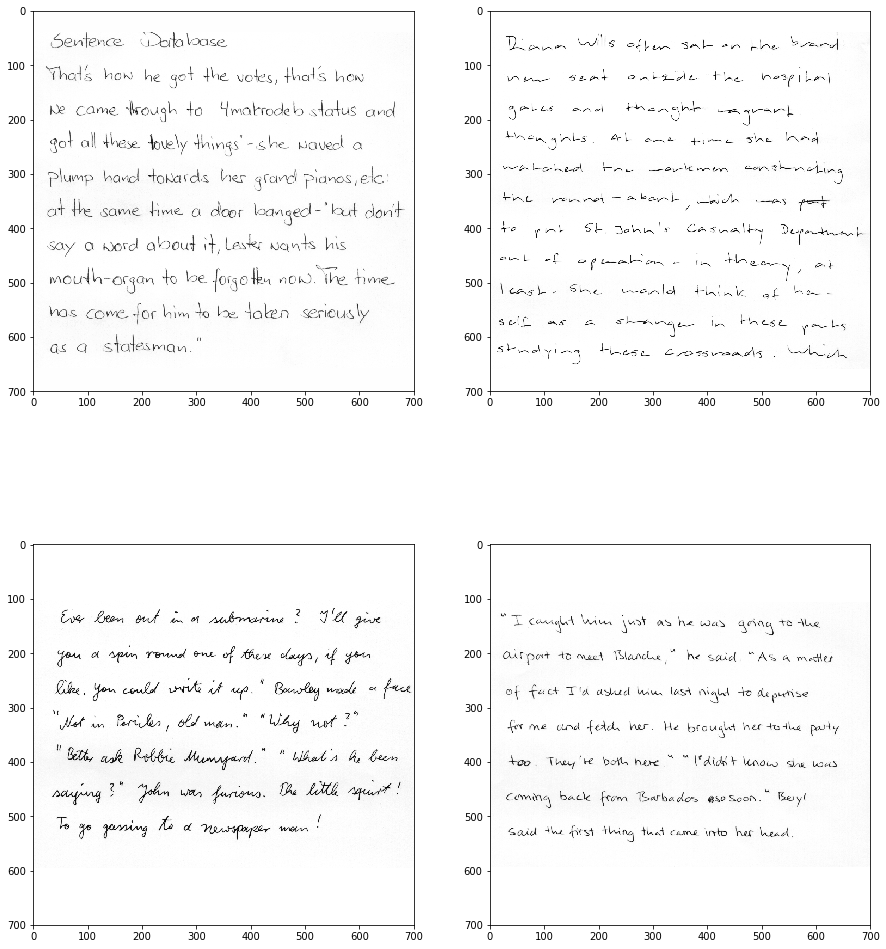

In [25]:
fig, axs = plt.subplots(int(len(images)/2), 2, figsize=(15, 9 * len(images)/2))

paragraph_segmented_images = []

for i, image in enumerate(images):
    s_y, s_x = int(i/2), int(i%2)

    bb = predicted_bbs[i]
    expanded_bb = expand_bounding_box(bb)
    image = crop_image(image, expanded_bb)

    image, _ = resize_image(image, desired_size=(700, 700))
    paragraph_segmented_images.append(image)
    
    axs[s_y, s_x].imshow(image, cmap='Greys_r')

## Line/word segmentation

In [26]:
def predict_bounding_boxes(net, image, bb, min_c, overlap_thres, topk):
    '''
    Given the outputs of the dataset (image and bounding box) and the network, 
    the predicted bounding boxes are provided.
    
    Parameters
    ----------
    net: SSD
    The trained SSD network.
    
    image: np.array
    A grayscale image of the handwriting passages.
        
    Returns
    -------
    predicted_bb: [(x, y, w, h)]
    The predicted bounding boxes.
    '''
    image = mx.nd.array(image).expand_dims(axis=2)
    image = mx.image.resize_short(image, 350)
    image = image.transpose([2, 0, 1])/255.

    image = image.as_in_context(ctx)
    image = image.expand_dims(0)
    
    bb = mx.nd.array(bb)
    bb = bb.as_in_context(ctx)
    bb = bb.expand_dims(axis=0)

    default_anchors, class_predictions, box_predictions = net(image)
           
    box_target, box_mask, cls_target = net.training_targets(default_anchors, 
                                                            class_predictions, bb)

    cls_probs = mx.nd.SoftmaxActivation(mx.nd.transpose(class_predictions, (0, 2, 1)), mode='channel')

    predicted_bb = MultiBoxDetection(*[cls_probs, box_predictions, default_anchors], force_suppress=True, clip=False)
    predicted_bb = box_nms(predicted_bb, overlap_thresh=overlap_thres, valid_thresh=min_c, topk=topk)
    predicted_bb = predicted_bb.asnumpy()
    predicted_bb = predicted_bb[0, predicted_bb[0, :, 0] != -1]
    predicted_bb = predicted_bb[:, 2:]
    predicted_bb[:, 2] = predicted_bb[:, 2] - predicted_bb[:, 0]
    predicted_bb[:, 3] = predicted_bb[:, 3] - predicted_bb[:, 1]

    return predicted_bb

In [27]:
word_segmentation_net = WordSegmentationNet(2, ctx=ctx)
word_segmentation_net.load_parameters("models/word_segmentation.params")

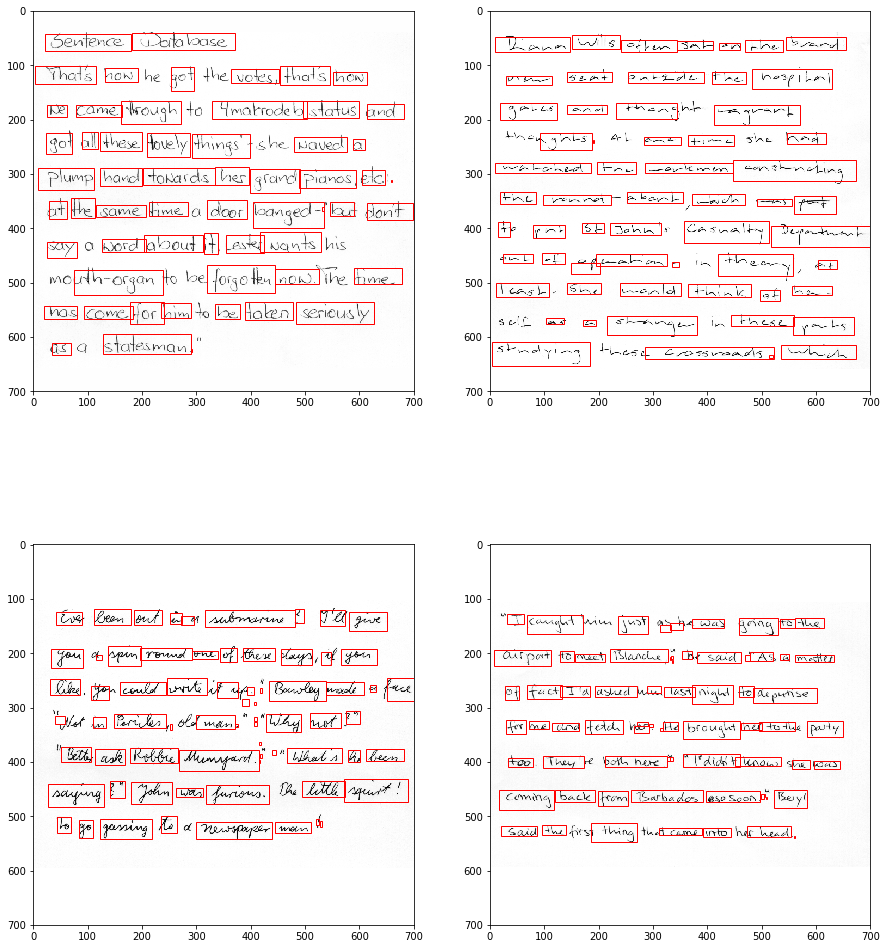

In [28]:
min_c = 0.01
overlap_thres = 0.001
topk = 250

fig, axs = plt.subplots(int(len(paragraph_segmented_images)/2), 2, 
                        figsize=(15, 9 * int(len(paragraph_segmented_images)/2)))
predicted_words_bbs_array = []

for i, paragraph_segmented_image in enumerate(paragraph_segmented_images):
    s_y, s_x = int(i/2), int(i%2)

    bb = np.zeros(shape=(13, 5))
    predicted_bb = predict_bounding_boxes(
        word_segmentation_net, paragraph_segmented_image, bb,
        min_c, overlap_thres, topk)
    
    predicted_words_bbs_array.append(predicted_bb)
    
    axs[s_y, s_x].imshow(paragraph_segmented_image, cmap='Greys_r')

    for j in range(predicted_bb.shape[0]):
        (x, y, w, h) = expand_bounding_box(predicted_bb[j], expand_bb_scale_x=0.1,
                                           expand_bb_scale_y=0.02)
        image_h, image_w = paragraph_segmented_image.shape[-2:]
        (x, y, w, h) = (x * image_w, y * image_h, w * image_w, h * image_h)
        rect = patches.Rectangle((x, y), w, h, fill=False, color="r")
        axs[s_y, s_x].add_patch(rect)

#### Word to line image processing

In [29]:
def clip_value(value, max_value):
    output = value
    if output < 0:
        output = 0
    if output > max_value:
        output = max_value
    return int(output)
    
word_images_array = []
LINE_CUTOFF = 0.05

for i, paragraph_segmented_image in enumerate(paragraph_segmented_images):

    predicted_bbs = predicted_words_bbs_array[i]
    
    word_images = []
    for j in range(predicted_bbs.shape[0]):
        (x, y, w, h) = expand_bounding_box(predicted_bbs[j], expand_bb_scale_x=0.1,
                                           expand_bb_scale_y=0.01)

        image_h, image_w = paragraph_segmented_image.shape[-2:]
        (x, y, w, h) = (x * image_w, y * image_h, w * image_w, h * image_h)
        x1 = clip_value(x, max_value=image_w)
        x2 = clip_value(x + w, max_value=image_w)
        y1 = clip_value(y, max_value=image_h)
        y2 = clip_value(y + h, max_value=image_h)
        
        word_image = paragraph_segmented_image[y1:y2, x1:x2]        
        word_images.append(word_image)
    
    # sort bounding boxes line to line
    y_indexes = np.argsort(predicted_bbs[:, 1])
    x_coords_in_a_line = []
    word_images_in_page = []
    word_images_in_a_line = []
    previous_y_value = None
    for y_index in y_indexes:
        y_value = predicted_bbs[y_index, 1]

        x_coords_in_a_line.append(predicted_bbs[y_index, 0])
        word_images_in_a_line.append(word_images[y_index])
        if previous_y_value is not None and y_value - previous_y_value > LINE_CUTOFF:
            # Sort word images by x direction
            x_indexes = np.argsort(x_coords_in_a_line)
            sorted_word_images_in_a_line = []
            for x_index in x_indexes:
                sorted_word_images_in_a_line.append(word_images_in_a_line[x_index])
            word_images_in_page.append(word_images_in_a_line)
            word_images_in_a_line = []
            x_coords_in_a_line = []
        previous_y_value = y_value
            
    word_images_array.append(word_images_in_page)

# Handwriting recognition

In [33]:
handwriting_line_recognition_net = HandwritingRecognitionNet(ctx=ctx)
handwriting_line_recognition_net.load_parameters("models/handwriting_line_recognition.params")

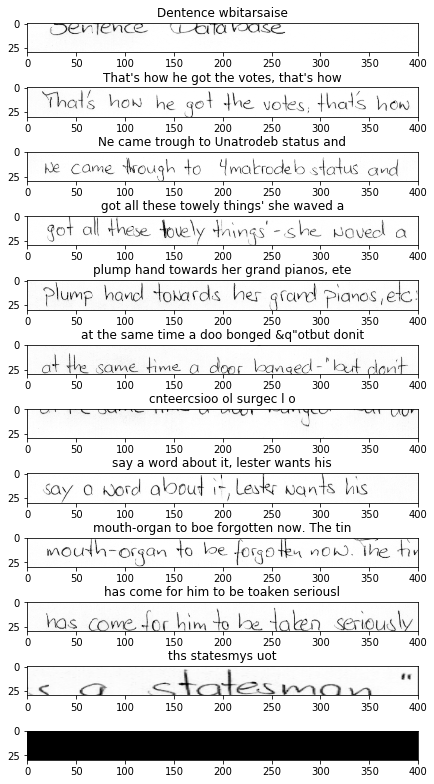

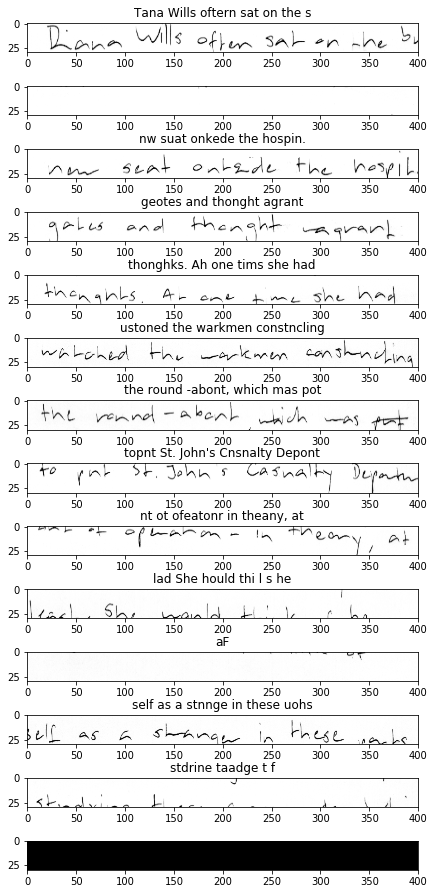

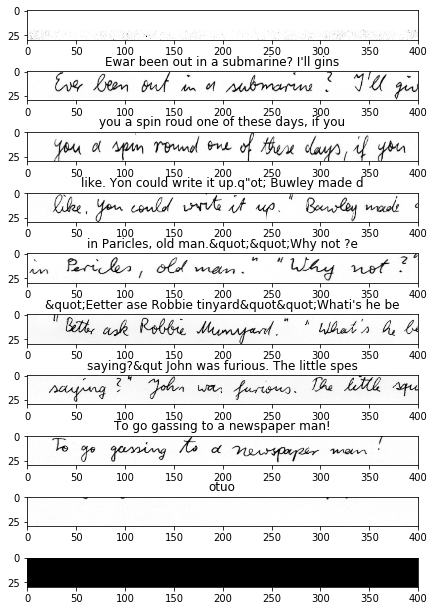

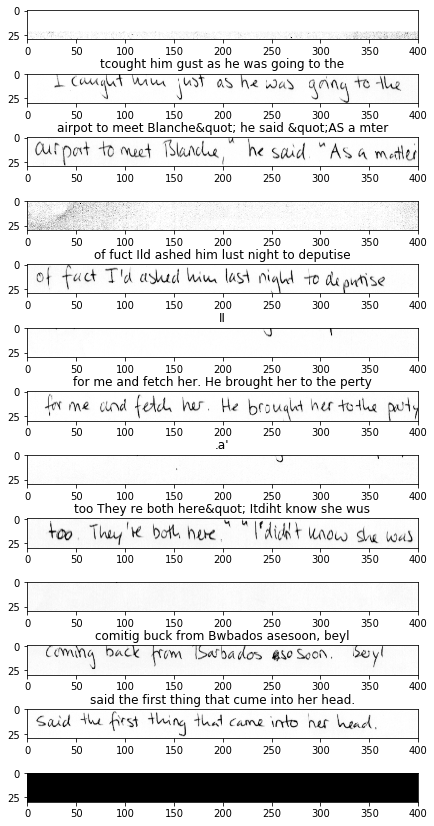

In [34]:
line_image_size = (30, 400)

for line_images in line_images_array:
    fig, axs = plt.subplots(len(line_images) + 1, figsize=(7, int(1 + 1.2 * len(line_images))))
    for i, line_image in enumerate(line_images):            
        line_image = skimage_tf.resize(line_image, line_image_size, mode='constant')

        line_image = mx.nd.array(line_image)
        line_image = line_image.as_in_context(ctx)
        line_image = line_image.expand_dims(0).expand_dims(0)

        character_probabilities = handwriting_line_recognition_net(line_image)
        character_predictions = character_probabilities.softmax().topk(axis=2).asnumpy()
        decoded_text = decoder_handwriting(character_predictions)

        axs[i].imshow(line_image.asnumpy().squeeze(), cmap='Greys_r')
        axs[i].set_title("{}".format(decoded_text[0]))
    axs[-1].imshow(np.zeros(shape=line_image_size), cmap='Greys_r')
